In [1]:
import pandas as pd
import numpy as np
import re
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from collections import Counter
import time
from tqdm import tqdm
import spacy
import string

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

print("Initializing models and tools...")
start_time = time.time()

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert", num_labels=3)
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
analyzer = SentimentIntensityAnalyzer()
spacy_nlp = spacy.load("en_core_web_sm")

print(f"Initialization completed in {time.time() - start_time:.2f} seconds")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Initializing models and tools...
Initialization completed in 1.60 seconds


In [2]:
print("Reading data...")
df = pd.read_csv(r'C:\Users\Administrator\Desktop\DSP391m_cryptocurrency-price-prediction\data\processed\BTC_news\BTC_news.csv')
print(f"Data loaded. Shape: {df.shape}")

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation + string.digits))
    text = re.sub(r'\s+', ' ', text).strip()
    
    words = text.split()
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)
    
    return text

df['Processed_Text'] = df['Title'] + " " + df['Content']
df['Processed_Text'] = df['Processed_Text'].apply(preprocess_text)

Reading data...
Data loaded. Shape: (2133, 3)


In [3]:
def get_textblob_sentiment(text):
    return TextBlob(text).sentiment.polarity

def get_vader_sentiment(text):
    return analyzer.polarity_scores(text)['compound']

def get_bert_sentiment(text):
    sentiment_dict = nlp(text[:512])
    if sentiment_dict[0]['label'] == 'positive':
        return sentiment_dict[0]['score']
    elif sentiment_dict[0]['label'] == 'neutral':
        return 0
    else:
        return -sentiment_dict[0]['score']

crypto_lexicon = {
    "bull": 1, "bullish": 1, "bear": -1, "bearish": -1, 
    "moon": 2, "dump": -2, "hodl": 1, "fud": -1,
    "whale": 0.5, "dip": -0.5, "pump": 1, "crash": -2,
    "adoption": 1, "ban": -1, "regulation": -0.5, "defi": 0.5,
    "halving": 0.5, "mining": 0.5, "wallet": 0.5, "exchange": 0.5,
    "blockchain": 0.5, "decentralized": 0.5, "centralized": -0.5,
    "scam": -2, "fraud": -2, "hack": -1, "security": 0.5,
    "volatile": -0.5, "stability": 0.5, "investment": 0.5
}

def crypto_specific_sentiment(text):
    words = text.lower().split()
    sentiment_scores = [crypto_lexicon.get(word, 0) for word in words]
    if sentiment_scores:
        return sum(sentiment_scores) / len(sentiment_scores)
    return 0

def analyze_complexity(text):
    doc = spacy_nlp(text)
    has_contrast = any(token.dep_ == "conj" and token.head.pos_ == "VERB" for token in doc)
    num_entities = len(doc.ents)
    num_noun_chunks = len(list(doc.noun_chunks))
    return [1 if has_contrast else 0, num_entities, num_noun_chunks]

def get_text_length(text):
    return len(text.split())

def get_keyword_frequency(text, keywords):
    words = text.lower().split()
    return sum(words.count(keyword.lower()) for keyword in keywords)

In [4]:
print("Applying sentiment analysis and calculating new features...")
tqdm.pandas()
df['TextBlob_Sentiment'] = df['Processed_Text'].progress_apply(get_textblob_sentiment)
df['VADER_Sentiment'] = df['Processed_Text'].progress_apply(get_vader_sentiment)
df['BERT_Sentiment'] = df['Processed_Text'].progress_apply(get_bert_sentiment)
df['Crypto_Sentiment'] = df['Processed_Text'].progress_apply(crypto_specific_sentiment)
df[['Has_Contrast', 'Num_Entities', 'Num_Noun_Chunks']] = df['Processed_Text'].progress_apply(analyze_complexity).tolist()
df['Text_Length'] = df['Processed_Text'].apply(get_text_length)
df['Crypto_Keyword_Freq'] = df['Processed_Text'].apply(lambda x: get_keyword_frequency(x, ['bitcoin', 'crypto', 'blockchain']))

Applying sentiment analysis and calculating new features...


100%|██████████| 2133/2133 [00:19<00:00, 111.82it/s]


In [5]:
print("Calculating ensemble sentiment...")
X = df[['TextBlob_Sentiment', 'VADER_Sentiment', 'BERT_Sentiment', 'Crypto_Sentiment', 
        'Has_Contrast', 'Num_Entities', 'Num_Noun_Chunks', 'Text_Length', 'Crypto_Keyword_Freq']]
y = (df['TextBlob_Sentiment'] + df['VADER_Sentiment'] + df['BERT_Sentiment'] + df['Crypto_Sentiment']) / 4

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

df['Ensemble_Sentiment'] = rf_model.predict(X)

print("Analyzing disagreement cases...")
df['Max_Difference'] = df[['TextBlob_Sentiment', 'VADER_Sentiment', 'BERT_Sentiment', 'Crypto_Sentiment']].max(axis=1) - df[['TextBlob_Sentiment', 'VADER_Sentiment', 'BERT_Sentiment', 'Crypto_Sentiment']].min(axis=1)
disagreement_cases = df[df['Max_Difference'] > 1].sort_values('Max_Difference', ascending=False)

def analyze_case(row):
    text = row['Processed_Text']
    print(f"Text: {text[:100]}...")
    print(f"TextBlob: {row['TextBlob_Sentiment']:.2f}")
    print(f"VADER: {row['VADER_Sentiment']:.2f}")
    print(f"BERT: {row['BERT_Sentiment']:.2f}")
    print(f"Crypto: {row['Crypto_Sentiment']:.2f}")
    print(f"Ensemble: {row['Ensemble_Sentiment']:.2f}")
    print(f"Has Contrast: {row['Has_Contrast']}")
    print(f"Number of Entities: {row['Num_Entities']}")
    print(f"Number of Noun Chunks: {row['Num_Noun_Chunks']}")
    print(f"Text Length: {row['Text_Length']}")
    print(f"Crypto Keyword Frequency: {row['Crypto_Keyword_Freq']}")
    print("Analysis:")
    
    if row['TextBlob_Sentiment'] * row['VADER_Sentiment'] < 0 or row['TextBlob_Sentiment'] * row['BERT_Sentiment'] < 0 or row['VADER_Sentiment'] * row['BERT_Sentiment'] < 0:
        print("- Models disagree on the sentiment direction")
    
    if abs(row['TextBlob_Sentiment'] - row['VADER_Sentiment']) > 0.5 or abs(row['TextBlob_Sentiment'] - row['BERT_Sentiment']) > 0.5 or abs(row['VADER_Sentiment'] - row['BERT_Sentiment']) > 0.5:
        print("- Large disagreement between models")
    
    print("\nPossible explanations:")
    if "not" in text.lower() or "n't" in text.lower():
        print("- The text contains negations")
    if row['Text_Length'] > 50:
        print("- The text is relatively long")
    if row['Has_Contrast']:
        print("- The text contains contrasting statements")
    if row['Num_Entities'] > 5:
        print("- The text contains many named entities")
    if row['Num_Noun_Chunks'] > 10:
        print("- The text has a complex structure with many noun phrases")
    if row['Crypto_Keyword_Freq'] > 3:
        print("- The text contains many cryptocurrency-related keywords")
    
    doc = spacy_nlp(text)
    important_phrases = [chunk.text for chunk in doc.noun_chunks]
    print(f"Important phrases: {important_phrases[:5]}")
    
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    print(f"Named entities: {entities[:5]}")
    print("\n")

print("Analyzing top 5 disagreement cases...")
disagreement_cases.head(5).apply(analyze_case, axis=1)

Calculating ensemble sentiment...
Analyzing disagreement cases...
Analyzing top 5 disagreement cases...
Text: bitcoin miners face revenue decline due upcoming code update according bloomberg bitcoin miners brac...
TextBlob: 0.04
VADER: 0.98
BERT: -0.96
Crypto: 0.03
Ensemble: 0.02
Has Contrast: 1
Number of Entities: 9
Number of Noun Chunks: 34
Text Length: 150
Crypto Keyword Frequency: 10
Analysis:
- Models disagree on the sentiment direction
- Large disagreement between models

Possible explanations:
- The text is relatively long
- The text contains contrasting statements
- The text contains many named entities
- The text has a complex structure with many noun phrases
- The text contains many cryptocurrency-related keywords
Important phrases: ['bitcoin miners', 'revenue decline', 'upcoming code update', 'bloomberg bitcoin miners', 'significant drop revenue']
Named entities: [('bloomberg bitcoin', 'PERSON'), ('later week', 'DATE'), ('every four years', 'DATE'), ('fourth', 'ORDINAL'), ('

548    None
793    None
213    None
761    None
843    None
dtype: object

Analyzing common words in disagreement cases...
Most common words in disagreement cases:
[('bitcoin', 1799), ('market', 755), ('price', 673), ('according', 495), ('bitcoins', 380), ('million', 372), ('btc', 343), ('data', 339), ('could', 322), ('significant', 298), ('etfs', 268), ('increase', 257), ('investors', 239), ('may', 237), ('usdt', 228), ('miners', 227), ('trading', 227), ('cryptocurrency', 220), ('however', 209), ('halving', 204)]
Plotting sentiment over time...


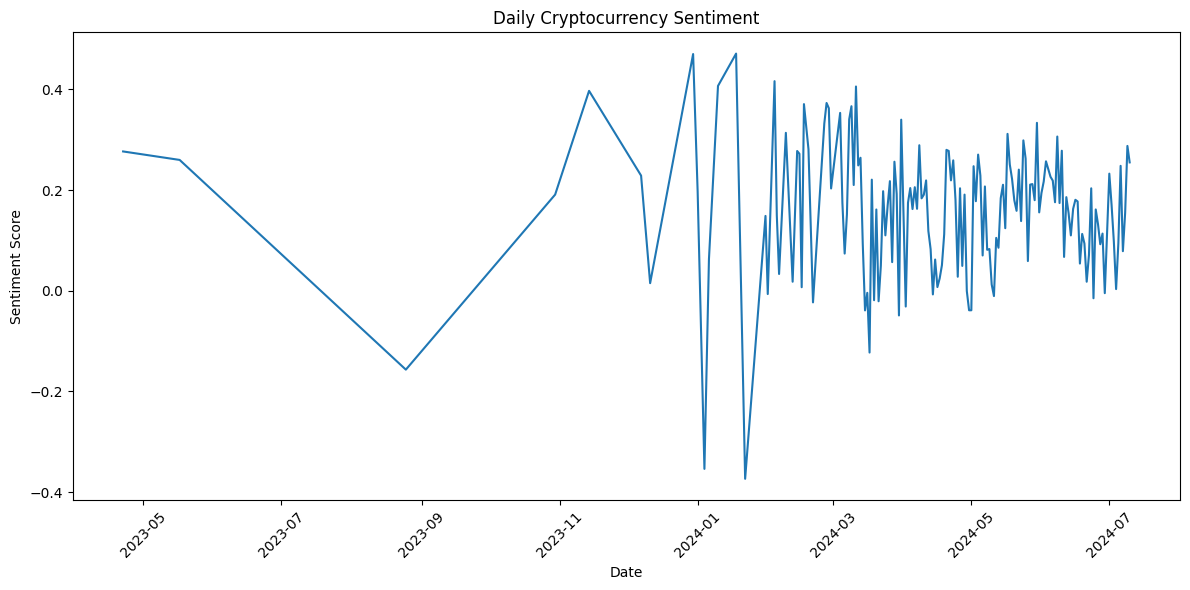

In [6]:
print("Analyzing common words in disagreement cases...")
words = ' '.join(disagreement_cases['Processed_Text']).split()
word_freq = Counter(words)
print("Most common words in disagreement cases:")
print(word_freq.most_common(20))

print("Plotting sentiment over time...")
df['Date'] = pd.to_datetime(df['Date'])
daily_sentiment = df.groupby('Date')['Ensemble_Sentiment'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(daily_sentiment['Date'], daily_sentiment['Ensemble_Sentiment'])
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Daily Cryptocurrency Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Performing cross-validation...
Mean Training R2 Score: 0.9972702388950474
Mean Validation R2 Score: 0.9938010859286626
Mean MSE: 0.0004194856171931098
Feature importance:
               feature  importance
2       BERT_Sentiment    0.797876
1      VADER_Sentiment    0.196533
0   TextBlob_Sentiment    0.004376
3     Crypto_Sentiment    0.000281
5         Num_Entities    0.000241
7          Text_Length    0.000234
6      Num_Noun_Chunks    0.000210
8  Crypto_Keyword_Freq    0.000189
4         Has_Contrast    0.000062
Plotting feature importance...


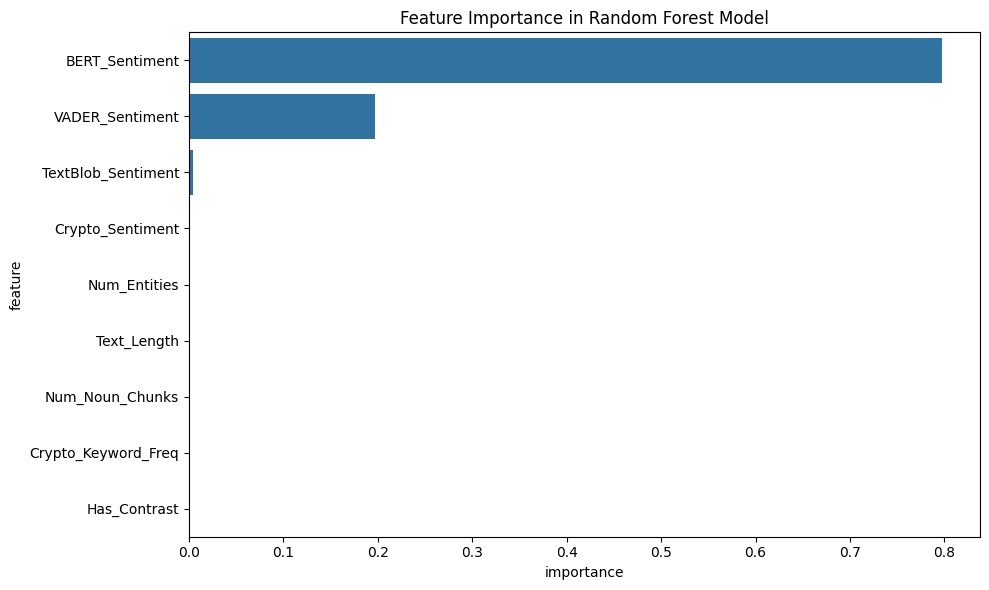

In [7]:
print("Performing cross-validation...")
kf = KFold(n_splits=10, shuffle=True, random_state=42)
mse_scores = []
r2_scores = []
train_scores = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    model = RandomForestRegressor(
        n_estimators=50,  
        max_depth=10,    
        min_samples_split=5,  
        min_samples_leaf=2, 
        max_features='sqrt',
        random_state=42
    )
    model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    
    train_scores.append(r2_score(y_train, train_pred))
    r2_scores.append(r2_score(y_val, val_pred))
    mse_scores.append(mean_squared_error(y_val, val_pred))

print("Mean Training R2 Score:", np.mean(train_scores))
print("Mean Validation R2 Score:", np.mean(r2_scores))
print("Mean MSE:", np.mean(mse_scores))

print("Feature importance:")
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print(feature_importance)

print("Plotting feature importance...")
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in Random Forest Model')
plt.tight_layout()
plt.show()

In [8]:
print("Displaying final results...")
print(df[['Date', 'Processed_Text', 'TextBlob_Sentiment', 'VADER_Sentiment', 'BERT_Sentiment', 'Crypto_Sentiment', 'Ensemble_Sentiment', 'Has_Contrast', 'Num_Entities', 'Num_Noun_Chunks', 'Text_Length', 'Crypto_Keyword_Freq']].head())

print("Saving results...")
df.to_csv('sentiment_analysis_results.csv', index=False)
daily_sentiment.to_csv('daily_sentiment_results.csv', index=False)

print(f"Total execution time: {time.time() - start_time:.2f} seconds")
print("Analysis completed!")

Displaying final results...
        Date                                     Processed_Text  \
0 2023-04-22  telegram allows wallet users buy exchange with...   
1 2023-05-17  jordan peterson bitcoin alternative cbdc famou...   
2 2023-08-25  finance professor changes stance bitcoin calls...   
3 2023-10-30  binance market update global cryptocurrency ma...   
4 2023-11-14  hive blockchain purchase sk pro miners bitmain...   

   TextBlob_Sentiment  VADER_Sentiment  BERT_Sentiment  Crypto_Sentiment  \
0            0.114394           0.9595        0.000000          0.034934   
1            0.058908           0.9716        0.000000          0.009921   
2           -0.020212          -0.6261        0.000000         -0.003425   
3            0.151786           0.6124        0.000000          0.000000   
4           -0.250000           0.8225        0.896529          0.045455   

   Ensemble_Sentiment  Has_Contrast  Num_Entities  Num_Noun_Chunks  \
0            0.276766             1       

Performing Exploratory Data Analysis...


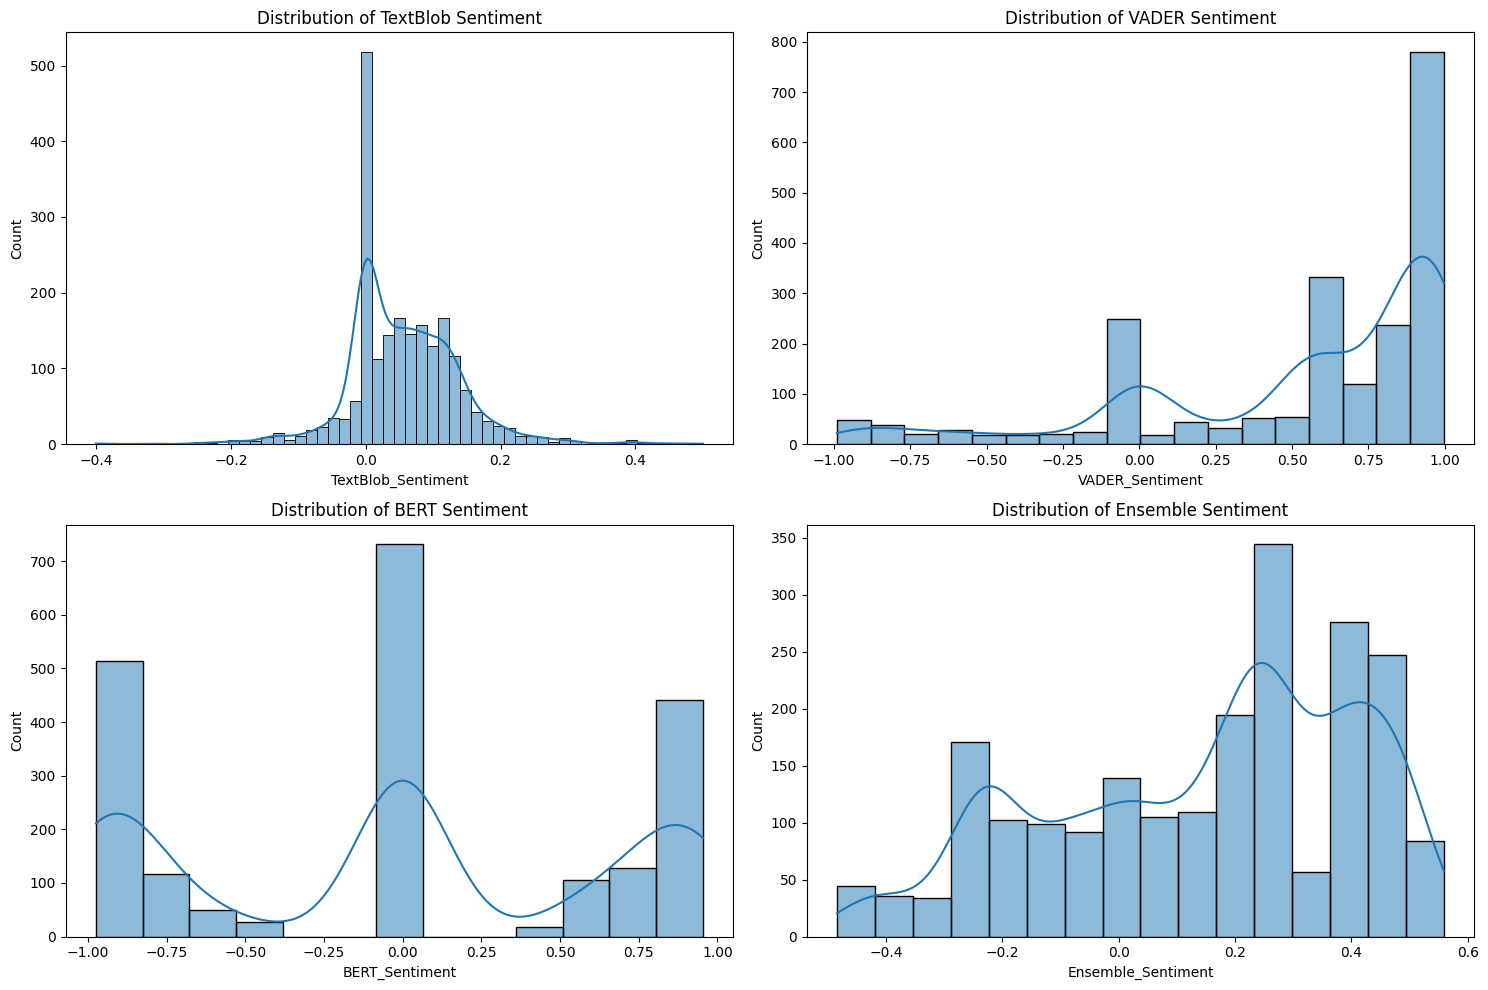

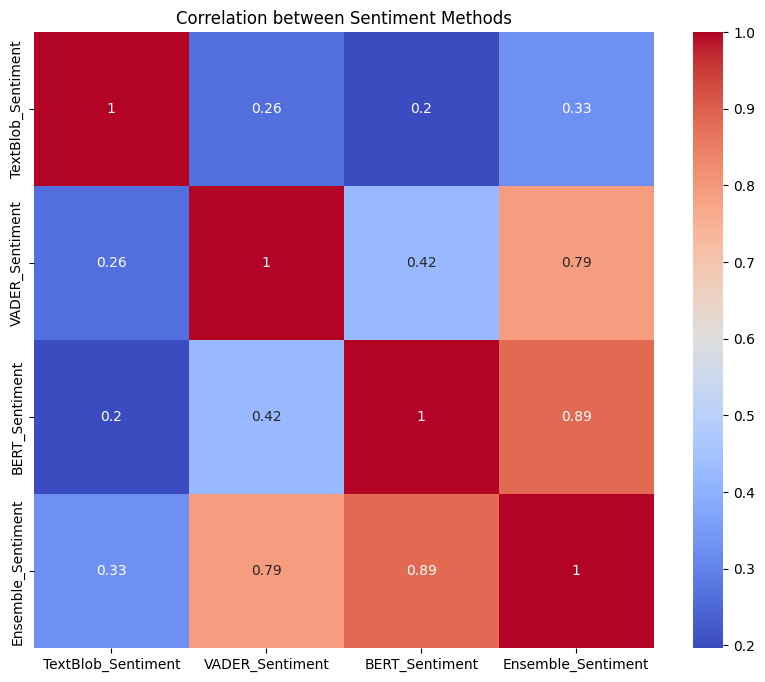

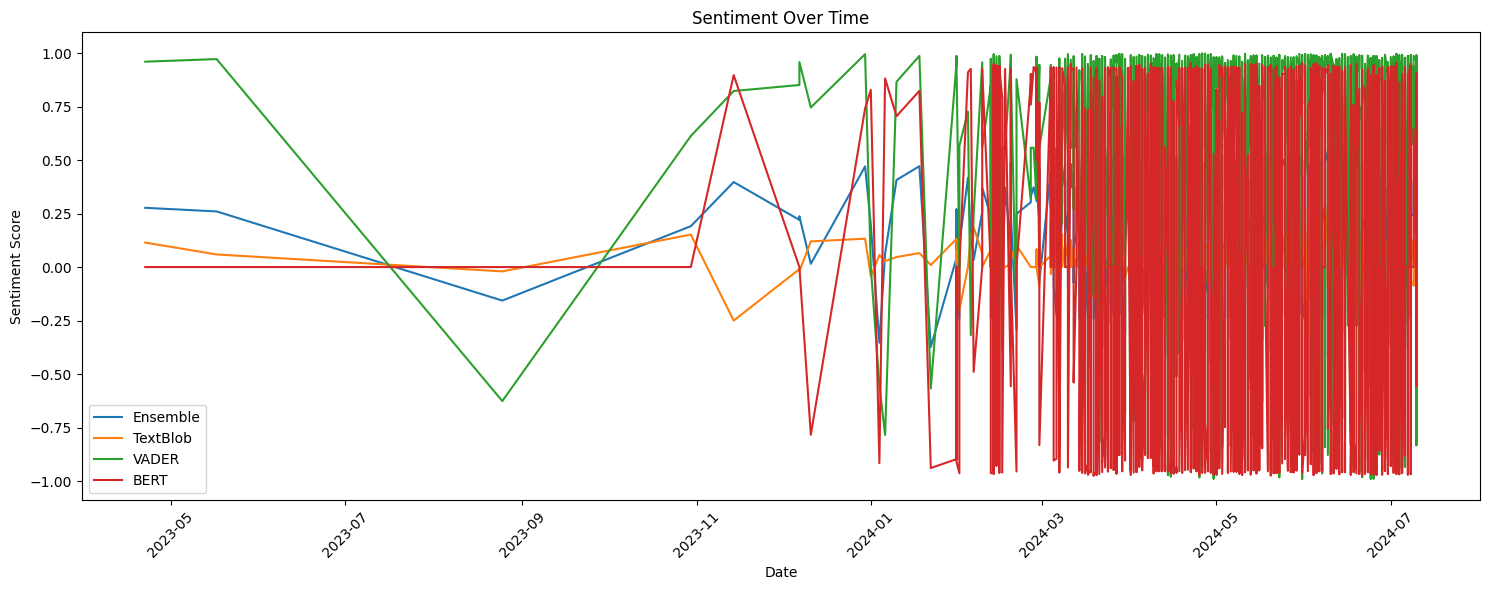

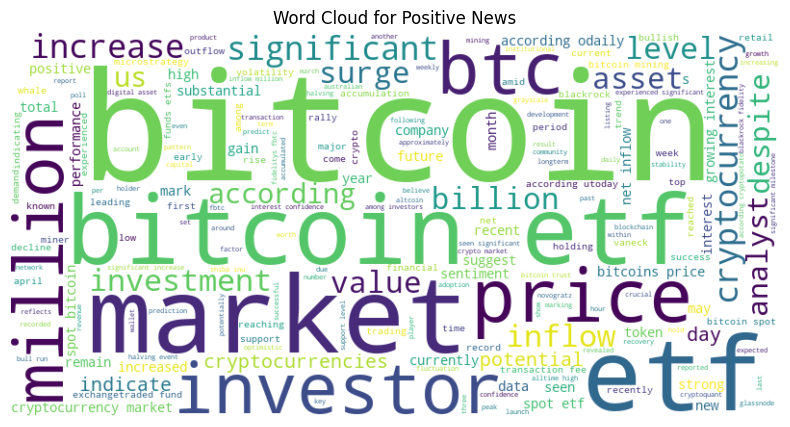

ValueError: We need at least 1 word to plot a word cloud, got 0.

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from wordcloud import WordCloud

print("Performing Exploratory Data Analysis...")

# 1. Phân phối của các điểm sentiment
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.histplot(df['TextBlob_Sentiment'], kde=True)
plt.title('Distribution of TextBlob Sentiment')

plt.subplot(2, 2, 2)
sns.histplot(df['VADER_Sentiment'], kde=True)
plt.title('Distribution of VADER Sentiment')

plt.subplot(2, 2, 3)
sns.histplot(df['BERT_Sentiment'], kde=True)
plt.title('Distribution of BERT Sentiment')

plt.subplot(2, 2, 4)
sns.histplot(df['Ensemble_Sentiment'], kde=True)
plt.title('Distribution of Ensemble Sentiment')

plt.tight_layout()
plt.show()

# 2. Tương quan giữa các phương pháp sentiment
correlation_matrix = df[['TextBlob_Sentiment', 'VADER_Sentiment', 'BERT_Sentiment', 'Ensemble_Sentiment']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation between Sentiment Methods')
plt.show()

# 3. Sentiment theo thời gian
plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['Ensemble_Sentiment'], label='Ensemble')
plt.plot(df['Date'], df['TextBlob_Sentiment'], label='TextBlob')
plt.plot(df['Date'], df['VADER_Sentiment'], label='VADER')
plt.plot(df['Date'], df['BERT_Sentiment'], label='BERT')
plt.title('Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Word Cloud cho tin tức tích cực và tiêu cực
def create_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

positive_news = ' '.join(df[df['Ensemble_Sentiment'] > 0.5]['Processed_Text'])
negative_news = ' '.join(df[df['Ensemble_Sentiment'] < -0.5]['Processed_Text'])

create_wordcloud(positive_news, 'Word Cloud for Positive News')
create_wordcloud(negative_news, 'Word Cloud for Negative News')

# 5. Phân tích số lượng tin tức theo ngày
daily_news_count = df.groupby('Date').size().reset_index(name='News Count')

plt.figure(figsize=(15, 6))
plt.bar(daily_news_count['Date'], daily_news_count['News Count'])
plt.title('Number of News Articles per Day')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 6. Mối quan hệ giữa độ dài văn bản và sentiment
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Text_Length', y='Ensemble_Sentiment', data=df)
plt.title('Relationship between Text Length and Sentiment')
plt.xlabel('Text Length')
plt.ylabel('Ensemble Sentiment')
plt.show()


# 8. Phân phối của Crypto_Keyword_Freq
plt.figure(figsize=(10, 6))
sns.histplot(df['Crypto_Keyword_Freq'], kde=True)
plt.title('Distribution of Crypto Keyword Frequency')
plt.xlabel('Frequency')
plt.show()

print("EDA completed!")

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


# Bước 2: Kiểm tra dữ liệu thiếu
print("\nChecking for missing data:")
print(daily_sentiment.isnull().sum())

# Bước 3: Xử lý dữ liệu thiếu
print("\nHandling missing data...")
daily_sentiment['Ensemble_Sentiment'] = daily_sentiment['Ensemble_Sentiment'].interpolate(method='linear')

# Bước 4: Kiểm tra và xử lý dữ liệu trùng lặp
print("\nChecking for duplicates...")
duplicate_count = daily_sentiment.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")
if duplicate_count > 0:
    daily_sentiment = daily_sentiment.drop_duplicates()
    print("Duplicates removed.")

# Bước 5: Xử lý dữ liệu ngoại lai
print("\nHandling outliers...")
Q1 = daily_sentiment['Ensemble_Sentiment'].quantile(0.25)
Q3 = daily_sentiment['Ensemble_Sentiment'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
daily_sentiment['Ensemble_Sentiment'] = np.clip(daily_sentiment['Ensemble_Sentiment'], lower_bound, upper_bound)

# Bước 6: Chuẩn hóa dữ liệu sentiment
print("\nNormalizing sentiment data...")
scaler = MinMaxScaler()
daily_sentiment['Ensemble_Sentiment_Normalized'] = scaler.fit_transform(daily_sentiment[['Ensemble_Sentiment']])

# Bước 7: Đảm bảo định dạng ngày tháng phù hợp
print("\nEnsuring correct date format...")
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'])
daily_sentiment = daily_sentiment.sort_values('Date')

# Bước 8: Tạo các đặc trưng bổ sung từ sentiment
print("\nCreating additional features...")
daily_sentiment['Sentiment_7day_MA'] = daily_sentiment['Ensemble_Sentiment'].rolling(window=7).mean()
daily_sentiment['Sentiment_Change'] = daily_sentiment['Ensemble_Sentiment'].diff()
daily_sentiment['Sentiment_Volatility'] = daily_sentiment['Ensemble_Sentiment'].rolling(window=7).std()

# Bước 9: Xử lý dữ liệu thiếu cuối cùng
print("\nHandling any remaining missing data...")
daily_sentiment = daily_sentiment.dropna()

# Bước 10: Kiểm tra kết quả cuối cùng
print("\nFinal data overview:")
print(daily_sentiment.head())
print("\nData info:")
print(daily_sentiment.info())
print("\nDescriptive statistics:")
print(daily_sentiment.describe())

# Bước 11: Visualize dữ liệu
print("\nCreating visualizations...")
plt.figure(figsize=(12, 6))
plt.plot(daily_sentiment['Date'], daily_sentiment['Ensemble_Sentiment'])
plt.title('Daily Sentiment Trend')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.savefig('daily_sentiment_trend.png')
plt.close()

plt.figure(figsize=(10, 5))
daily_sentiment['Ensemble_Sentiment'].hist(bins=50)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.savefig('sentiment_distribution.png')
plt.close()

# Bước 12: Lưu dữ liệu đã xử lý
print("\nSaving processed data...")
daily_sentiment.to_csv(r'C:\Users\Administrator\Desktop\DSP391m_cryptocurrency-price-prediction\data\processed\BTC_news\BTC_sentiment_dataset.csv', index=False)

print("\nProcessing complete. Data saved to 'processed_daily_sentiment.csv'")
print("Visualization saved as 'daily_sentiment_trend.png' and 'sentiment_distribution.png'")


Checking for missing data:
Date                  0
Ensemble_Sentiment    0
dtype: int64

Handling missing data...

Checking for duplicates...
Number of duplicate rows: 0

Handling outliers...

Normalizing sentiment data...

Ensuring correct date format...

Creating additional features...

Handling any remaining missing data...

Final data overview:
         Date  Ensemble_Sentiment  Ensemble_Sentiment_Normalized  \
6  2023-12-11            0.015135                       0.297871   
7  2023-12-30            0.470245                       0.998625   
8  2024-01-01            0.197623                       0.578856   
9  2024-01-04           -0.178321                       0.000000   
10 2024-01-06            0.062862                       0.371359   

    Sentiment_7day_MA  Sentiment_Change  Sentiment_Volatility  
6            0.173166         -0.213641              0.185098  
7            0.200806          0.455111              0.215152  
8            0.191905         -0.272622        

In [ ]:
daily_sentiment.head()

,Date,Ensemble_Sentiment,Ensemble_Sentiment_Normalized,Sentiment_7day_MA,Sentiment_Change,Sentiment_Volatility
6,2024-06-16,0.181599,0.605648,0.159708,0.021124,0.067415
7,2024-06-17,0.180331,0.601296,0.145772,-0.001268,0.045403
8,2024-06-18,0.054891,0.170673,0.144231,-0.125441,0.048641
9,2024-06-19,0.117685,0.386237,0.134829,0.062794,0.046080
10,2024-06-20,0.098509,0.320408,0.128059,-0.019176,0.047637
